# Challenge Project - Runze Leng

# 1. Build a single dataset for multiple sources

### Import Packages

In [69]:
import sqlite3
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif, RFE
from matplotlib import pyplot
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from numpy import loadtxt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.tree import DecisionTreeClassifier


In [70]:
# creating file path
dbfile = 'C:/Users/rnlen/Desktop/ml_assessment.db'
# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)
# creating cursor
cur = con.cursor()


# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)
#[('loan_information',), ('enterprise_information',), ('scores_information',), ('disbursement_information',)]


# Import four tables to dataframe
df_loan_information = pd.read_sql_query("SELECT * from loan_information", con)
df_enterprise_information = pd.read_sql_query("SELECT * from enterprise_information", con)
df_scores_information = pd.read_sql_query("SELECT * from scores_information", con)
df_disbursement_information = pd.read_sql_query("SELECT * from disbursement_information", con)
# Be sure to close the connection
con.close()

[('loan_information',), ('enterprise_information',), ('scores_information',), ('disbursement_information',)]


In [71]:
# merge three tables on loan_id
df1 = pd.merge(df_enterprise_information, df_scores_information, how='outer', on='loan_id')
df2 = pd.merge(df1, df_loan_information, how='outer', on='loan_id')

df2.describe()

,loan_id,enterprise_id_x,ManagAgeui_APP,ManagCBscoreui_APP,customer_id,enterprise_id_y,hub_id
count,2476.000000,2475.000000,2473.000000,2473.000000,2476.000000,2475.000000,2476.000000
mean,34771.864701,23959.273939,38.264860,594.897291,70758.806947,23959.273939,43.886511
std,17263.360009,14534.358561,8.663885,289.479152,42834.934930,14534.358561,24.709423
min,304.000000,32.000000,20.000000,0.000000,6597.000000,32.000000,3.000000
25%,20910.250000,10590.500000,32.000000,556.000000,30589.750000,10590.500000,24.000000
50%,34944.500000,23960.000000,37.000000,733.000000,70246.000000,23960.000000,40.000000
75%,49721.000000,36499.500000,44.000000,793.000000,107932.500000,36499.500000,61.000000
max,65573.000000,50761.000000,69.000000,840.000000,150487.000000,50761.000000,99.000000


In [72]:
# drop duplicated enterprise_id
df2 = df2.drop(df2.columns[[10]], axis=1)
df2.describe()

,loan_id,enterprise_id_x,ManagAgeui_APP,ManagCBscoreui_APP,customer_id,hub_id
count,2476.000000,2475.000000,2473.000000,2473.000000,2476.000000,2476.000000
mean,34771.864701,23959.273939,38.264860,594.897291,70758.806947,43.886511
std,17263.360009,14534.358561,8.663885,289.479152,42834.934930,24.709423
min,304.000000,32.000000,20.000000,0.000000,6597.000000,3.000000
25%,20910.250000,10590.500000,32.000000,556.000000,30589.750000,24.000000
50%,34944.500000,23960.000000,37.000000,733.000000,70246.000000,40.000000
75%,49721.000000,36499.500000,44.000000,793.000000,107932.500000,61.000000
max,65573.000000,50761.000000,69.000000,840.000000,150487.000000,99.000000


In [73]:
# remove rows without account_number and merge to df2
a = df_disbursement_information['account_number'].astype('bool')
print(a)

df_disbursement_information_without_none = df_disbursement_information[a]

df_merge = pd.merge(df2, df_disbursement_information_without_none, how='left', on='account_number')
df_merge.shape

0       False
1        True
2       False
3       False
4        True
        ...  
2471    False
2472     True
2473     True
2474     True
2475    False
Name: account_number, Length: 2476, dtype: bool


(2476, 15)

In [74]:
df_merge.head(10)

,loan_id,business_type,business_activity,business_sector,enterprise_id_x,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,account_number,customer_id,screening_date,product_code,hub_id,total_disbursement_amount,disbursement_month
0,29321,None,Job Work,Machine Components,24500.0,27.0,None,776.0,None,71846,2018-04-19,None,53,NaN,NaN
1,13613,Trading,Retail,Electronics,10723.0,30.0,Invoice & Banked,616.0,TLWCU0003070,31083,2017-08-10,TLWCU,39,400000.0,Aug-2017
2,13921,None,Retail,Agriculture,11002.0,55.0,None,793.0,None,31928,2017-08-17,None,56,NaN,NaN
3,16520,None,Retail,Food & Beverage,13220.0,26.0,None,781.0,None,38660,2017-10-21,None,58,NaN,NaN
4,49742,Manufacturing,Job Work & Sales,Textiles,40426.0,30.0,Cash & Non Banked,689.0,TLWCS0012623,119694,2018-12-24,TLWCS,27,500000.0,Jan-2019
5,59718,Trading,Retail,Houseware,4346.0,29.0,Cash & Banked,757.0,None,12095,2019-04-17,None,25,NaN,NaN
6,65458,Manufacturing,Sales,Rubber,50738.0,49.0,Invoice & Non Banked,793.0,TLWCS0016745,150404,2019-06-26,TLWCS,41,400000.0,Jun-2019
7,20064,Manufacturing,Sales,Plastics,17187.0,34.0,Invoice & Banked,718.0,TLWCS0002705,49773,2017-11-17,TLWCS,34,500000.0,Dec-2017
8,37403,Trading,Whole Sale,Fashion,30965.0,42.0,Cash & Non Banked,539.0,None,91252,2018-08-21,None,98,NaN,NaN
9,11993,None,Sales,Food Products,9318.0,28.0,Cash & Non Banked,802.0,None,26816,2017-06-22,TLAPS,87,NaN,NaN


In [75]:
df_merge.describe()

,loan_id,enterprise_id_x,ManagAgeui_APP,ManagCBscoreui_APP,customer_id,hub_id,total_disbursement_amount
count,2476.000000,2475.000000,2473.000000,2473.000000,2476.000000,2476.000000,1.369000e+03
mean,34771.864701,23959.273939,38.264860,594.897291,70758.806947,43.886511,3.702370e+05
std,17263.360009,14534.358561,8.663885,289.479152,42834.934930,24.709423,3.084137e+05
min,304.000000,32.000000,20.000000,0.000000,6597.000000,3.000000,7.000000e+04
25%,20910.250000,10590.500000,32.000000,556.000000,30589.750000,24.000000,2.000000e+05
50%,34944.500000,23960.000000,37.000000,733.000000,70246.000000,40.000000,3.000000e+05
75%,49721.000000,36499.500000,44.000000,793.000000,107932.500000,61.000000,5.000000e+05
max,65573.000000,50761.000000,69.000000,840.000000,150487.000000,99.000000,3.500000e+06


# 2. Clean the Data

In [76]:
# remove four ID columns 
df = df_merge.drop(columns=['loan_id', 'customer_id','enterprise_id_x','hub_id'])


# test which date columns has more missing values and remove the higher one
df['disbursement_month'].isna().sum() #1107
df['screening_date'].isna().sum() #126
df = df.drop(columns=['disbursement_month']) 


### Drop missing values(under 5%)
df.isna().sum()
df = df.dropna(subset=['business_activity','business_sector','ManagAgeui_APP','ManagCBscoreui_APP','screening_date'])
df.isna().sum()

business_type                     462
business_activity                   0
business_sector                     0
ManagAgeui_APP                      0
BusinFormalityOfTheBusinessui     486
ManagCBscoreui_APP                  0
account_number                   1105
screening_date                      0
product_code                     1056
total_disbursement_amount        1105
dtype: int64

In [77]:
# Set dependent variable to 0/1
df['ManagCBscoreui_APP'] = np.where(df['ManagCBscoreui_APP'] < 700, 1, 0) ##<700 1 reject     ------        >=700 0 approve
df = df.rename(columns={'ManagCBscoreui_APP': 'loandecision'})
df['loandecision'].value_counts()


0    1375
1     973
Name: loandecision, dtype: int64

**How to impute the missing data**

Manufacturing    1023
Trading           855
Services            8
Name: business_type, dtype: int64

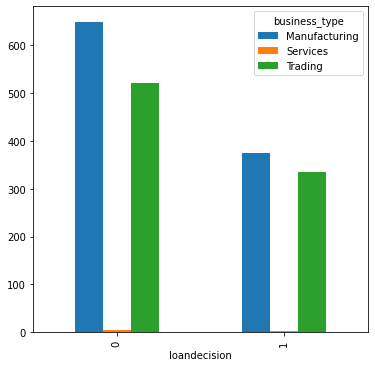

In [78]:
# If not impute missing values on business_type
j = pd.crosstab(df['loandecision'], df['business_type'])   
j.plot(kind = 'bar', stacked = False, figsize = (6,6))
df['business_type'].value_counts()

Manufacturing    1023
Trading           855
Unknown           462
Services            8
Name: business_type, dtype: int64

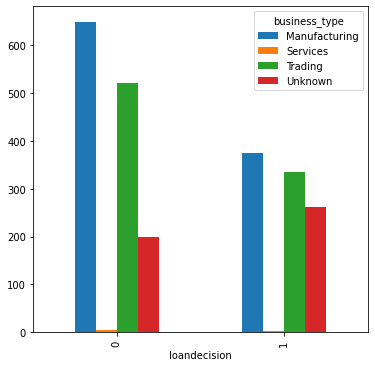

In [79]:
# IF impute missing values with "Unknown" on business_type
df_copy = df.copy()
df_copy['business_type'] = df_copy['business_type'].fillna("Unknown")
j = pd.crosstab(df_copy['loandecision'], df_copy['business_type'])   
j.plot(kind = 'bar', stacked = False, figsize = (6,6))
df_copy['business_type'].value_counts()

Trading          1317
Manufacturing    1023
Services            8
Name: business_type, dtype: int64

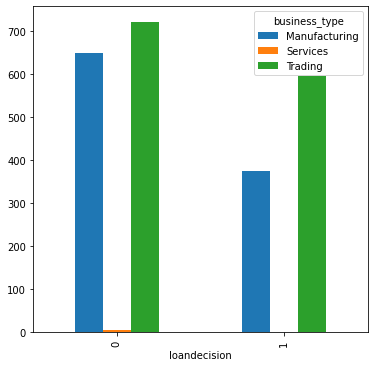

In [81]:
# If impute missing values with "Trading" on business_type
df_copy = df.copy()
imputer = SimpleImputer(missing_values=None, strategy='constant', fill_value='Trading') 
df_copy.business_type = imputer.fit_transform(df_copy['business_type'].values.reshape(-1,1))[:,0]
j = pd.crosstab(df_copy['loandecision'], df_copy['business_type'])   
j.plot(kind = 'bar', stacked = False, figsize = (6,6))
df_copy['business_type'].value_counts()

**Among the three graphs, the second one (imputing with "Unknown") shows that "Unknown" in business_type has a significant effect on the loan decision, so I go with this imputation method. 
Simillarly, Same imputation method is applied to business_activity, BusinFormalityOfTheBusinessui, product_code.**

In [88]:
df['business_type'] = df['business_type'].fillna("Unknown")

In [89]:
# Same as business_type
df['BusinFormalityOfTheBusinessui'] = df['BusinFormalityOfTheBusinessui'].fillna("Unknown")
df['BusinFormalityOfTheBusinessui'].value_counts()

Cash & Non Banked       1427
Unknown                  486
Invoice & Banked         220
Invoice & Non Banked     139
Cash & Banked             76
Name: BusinFormalityOfTheBusinessui, dtype: int64

In [90]:
df['total_disbursement_amount'] = df['total_disbursement_amount'].fillna(df['total_disbursement_amount'].median())
df['total_disbursement_amount'].value_counts()

300000.0    1293
200000.0     336
500000.0     178
400000.0     103
150000.0      91
            ... 
340000.0       1
120000.0       1
734000.0       1
520000.0       1
302000.0       1
Name: total_disbursement_amount, Length: 81, dtype: int64

In [91]:
df['product_code'] = df['product_code'].replace(regex={r'^....S$': 'S', r'^....U$': 'U'})
df['product_code'] = df['product_code'].fillna("Unknown")
df['product_code'].value_counts()

Unknown    1056
S           733
U           559
Name: product_code, dtype: int64

In [92]:
# categorize account_number
a = df['account_number'].astype('bool')
df['account_number'] = a.astype('category')
df['account_number'].value_counts()
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2348 entries, 0 to 2475
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   business_type                  2348 non-null   object  
 1   business_activity              2348 non-null   object  
 2   business_sector                2348 non-null   object  
 3   ManagAgeui_APP                 2348 non-null   float64 
 4   BusinFormalityOfTheBusinessui  2348 non-null   object  
 5   loandecision                   2348 non-null   int32   
 6   account_number                 2348 non-null   category
 7   screening_date                 2348 non-null   object  
 8   product_code                   2348 non-null   object  
 9   total_disbursement_amount      2348 non-null   float64 
dtypes: category(1), float64(2), int32(1), object(6)
memory usage: 176.7+ KB


business_type                    0
business_activity                0
business_sector                  0
ManagAgeui_APP                   0
BusinFormalityOfTheBusinessui    0
loandecision                     0
account_number                   0
screening_date                   0
product_code                     0
total_disbursement_amount        0
dtype: int64

In [101]:
# One hot encoding
df1 = pd.get_dummies(df, columns=["business_type", "business_activity"], prefix=["btype", "bactivity"])
df1.info()
df2 = pd.get_dummies(df1, columns=["business_sector", "BusinFormalityOfTheBusinessui"], prefix=["bsector", "bFormality"])
df2.info()
df3 = pd.get_dummies(df2, columns=["account_number", "product_code"], prefix=["account", "product"])
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2348 entries, 0 to 2475
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   business_sector                          2348 non-null   object  
 1   ManagAgeui_APP                           2348 non-null   float64 
 2   BusinFormalityOfTheBusinessui            2348 non-null   object  
 3   loandecision                             2348 non-null   int32   
 4   account_number                           2348 non-null   category
 5   screening_date                           2348 non-null   object  
 6   product_code                             2348 non-null   object  
 7   total_disbursement_amount                2348 non-null   float64 
 8   btype_Manufacturing                      2348 non-null   uint8   
 9   btype_Services                           2348 non-null   uint8   
 10  btype_Trading                       

In [102]:
df3['year'] = df3['screening_date'].replace(regex={r'^2008......$': '2008', r'^2014......$$': '2014', r'^2016......$$': '2016', 
                                                 r'^2017......$$': '2017', r'^2018......$$': '2018', r'^2019......$$': '2019'})
df3['month'] = df3['screening_date'].replace(regex={r'^.....01...$': '01', r'^.....02...$': '02', r'^.....03...$': '03', r'^.....04...$': '04',
                                                 r'^.....05...$': '05', r'^.....06...$': '06', r'^.....07...$': '07', r'^.....08...$': '08',
                                                 r'^.....09...$': '09', r'^.....10...$': '10', r'^.....11...$': '11', r'^.....12...$': '12'})
df3 = df3.drop(columns=['screening_date'])
df4 = pd.get_dummies(df3, columns=["year", "month"], prefix=["year", "month"])
data = df4
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2348 entries, 0 to 2475
Data columns (total 79 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ManagAgeui_APP                           2348 non-null   float64
 1   loandecision                             2348 non-null   int32  
 2   total_disbursement_amount                2348 non-null   float64
 3   btype_Manufacturing                      2348 non-null   uint8  
 4   btype_Services                           2348 non-null   uint8  
 5   btype_Trading                            2348 non-null   uint8  
 6   btype_Unknown                            2348 non-null   uint8  
 7   bactivity_Job Work                       2348 non-null   uint8  
 8   bactivity_Job Work & Sales               2348 non-null   uint8  
 9   bactivity_Retail                         2348 non-null   uint8  
 10  bactivity_Retail (Business to Business)  2348 no

# 3. Perform EDA

Approve    0.585605
Reject     0.414395
Name: loandecision, dtype: float64


<AxesSubplot:>

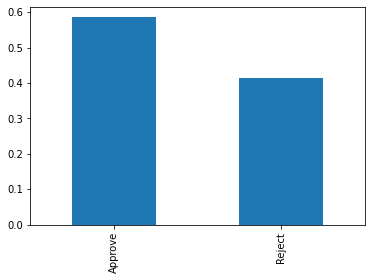

In [104]:
df_eda = df.copy()
df_eda['loandecision'] = np.where(df_eda['loandecision'] == 1, 'Reject', 'Approve') ##<700 1 reject     ------        >=700 0 approve
print(df_eda['loandecision'].value_counts(normalize=True))
df_eda['loandecision'].value_counts(normalize=True).plot.bar()

### Checking the proportion of Approved and Rejected loan. 41.4% loan applications are rejected in the dataset.

In [111]:
# Analyzing the categorical variables in the data
categorical_columns = ['business_type', 'business_activity', 'business_sector', 'BusinFormalityOfTheBusinessui','account_number','product_code']
for i in categorical_columns : 
     a = df_eda[i].value_counts(normalize = True)
     print(a)

Manufacturing    0.435690
Trading          0.364140
Unknown          0.196763
Services         0.003407
Name: business_type, dtype: float64
Retail                           0.311755
Sales                            0.212521
Job Work & Sales                 0.192930
Whole Sale                       0.152896
Job Work                         0.126065
Retail (Business to Customer)    0.002129
Retail (Business to Business)    0.001704
Name: business_activity, dtype: float64
Fashion                  0.133305
Food & Beverage          0.118399
Machine  Components      0.084753
Auto Components          0.080494
Fabrication              0.071976
Textiles                 0.070698
Plastics                 0.041738
Wood                     0.034923
Food Products            0.033220
Automobiles              0.029387
Electricals              0.028961
Construction             0.024702
Metal works              0.022998
Houseware                0.020017
Paper                    0.019591
Chemicals       

### 44% of the loan applications come from Manufacturing businesses. 
### 31% of the loan applications come from Retail businesses. 
### 13% of the loan applications come from Fashion sector.
### 61% come from Cash & Non Banked business formality. 

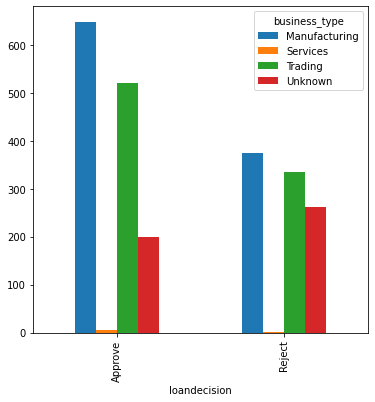

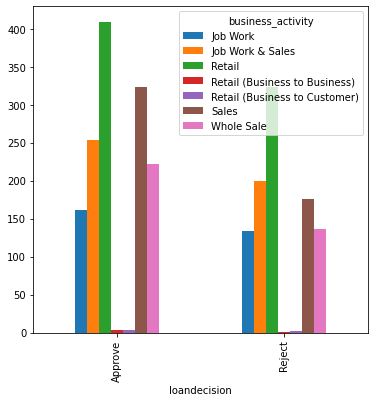

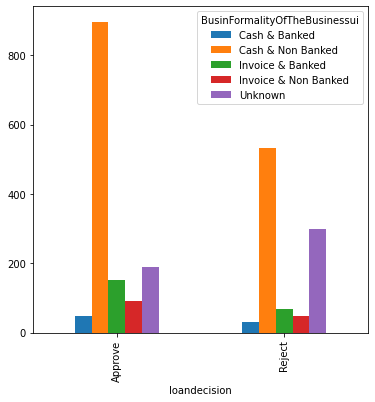

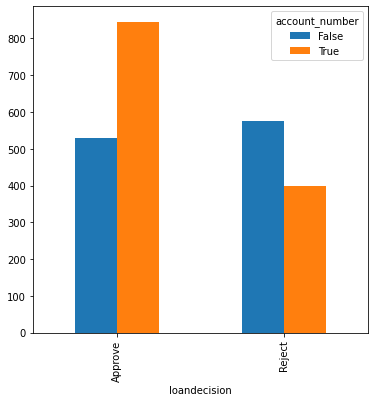

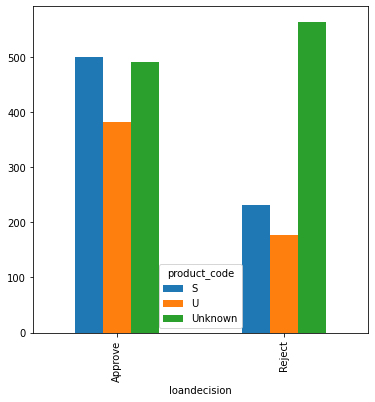

In [114]:
categorical_columns = ['business_type', 'business_activity', 'BusinFormalityOfTheBusinessui','account_number','product_code']
for i in categorical_columns:
    j = pd.crosstab(df_eda['loandecision'],df_eda[i])
    j.plot(kind = 'bar', stacked = False, figsize = (6,6))


total_disbursement_amount 337857.11 300000.0
ManagAgeui_APP 38.22 37.0


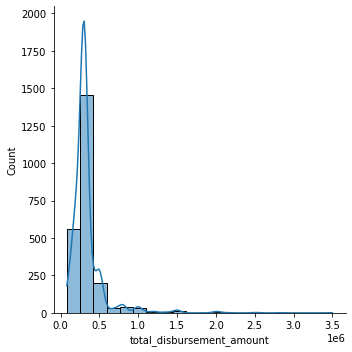

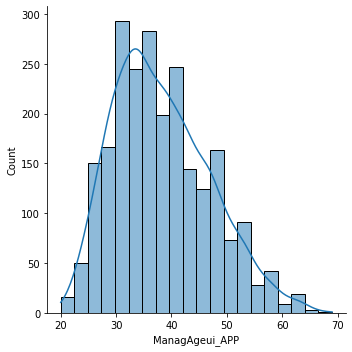

In [115]:
# Finding mean and median of the numerical columns
numerical_columns = ['total_disbursement_amount', 'ManagAgeui_APP']
for i in numerical_columns:
    print (i ,round(df_eda[i].mean(),2),round(df_eda[i].median(),2))
    
for idx,num_col in enumerate(numerical_columns):
    sns.displot(x= num_col,data=df_eda,bins=20,kde= True)
    plt.show()

# 4. Data Modeling

In [116]:
# drop the date columns and seperate data to x and y
data = data.drop(columns=data.columns[61:]) 
data = data.reset_index(drop=True)
data.info()
y = data['loandecision']
x = data.drop(columns=['loandecision'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ManagAgeui_APP                           2348 non-null   float64
 1   loandecision                             2348 non-null   int32  
 2   total_disbursement_amount                2348 non-null   float64
 3   btype_Manufacturing                      2348 non-null   uint8  
 4   btype_Services                           2348 non-null   uint8  
 5   btype_Trading                            2348 non-null   uint8  
 6   btype_Unknown                            2348 non-null   uint8  
 7   bactivity_Job Work                       2348 non-null   uint8  
 8   bactivity_Job Work & Sales               2348 non-null   uint8  
 9   bactivity_Retail                         2348 non-null   uint8  
 10  bactivity_Retail (Business to Business)  2348 no

**Dimension Reduction**

I plan to test the numerical features first, then test categorical features.

**For numerical features**

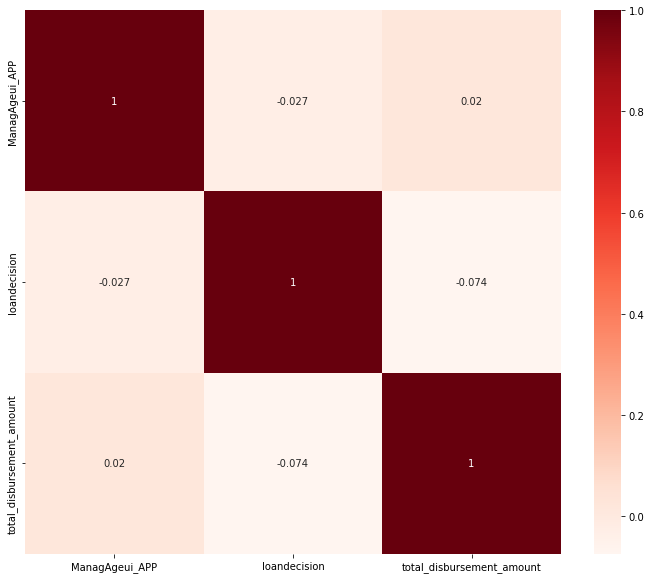

In [121]:
#Using Pearson Correlation
data_int = data[data.columns[0:3]] #(2348,2) int
plt.figure(figsize=(12,10))
cor = data_int.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Then I used "Chi-square" test and "Mutual Information measure" to test categorical features.

**For categorical features**

**Chi-square Test**

btype_Manufacturing: 9.642511
btype_Services: 0.890941
btype_Trading: 1.987676
btype_Unknown: 44.394111
bactivity_Job Work: 1.789944
bactivity_Job Work & Sales: 1.371531
bactivity_Retail: 2.176484
bactivity_Retail (Business to Business): 0.445471
bactivity_Retail (Business to Customer): 0.004270
bactivity_Sales: 7.825430
bactivity_Whole Sale: 1.589583
bsector_Agriculture: 0.146143
bsector_Apparel: 0.100464
bsector_Auto Components: 0.295155
bsector_Automobiles: 2.451344
bsector_Bedding: 2.122909
bsector_Bedding Industry: 0.004270
bsector_Book Stores: 4.897239
bsector_Chemicals: 0.055040
bsector_Construction: 2.587594
bsector_Construction Material: 0.477647
bsector_Electrical: 0.330453
bsector_Electricals: 0.200979
bsector_Electronics: 0.034157
bsector_Fabrication: 0.100758
bsector_Fashion: 0.142876
bsector_Food & Beverage: 0.261711
bsector_Food Products: 0.285049
bsector_Furniture: 3.933762
bsector_General: 2.426189
bsector_Handicrafts: 0.605994
bsector_Health & Beauty: 0.193569
bsector

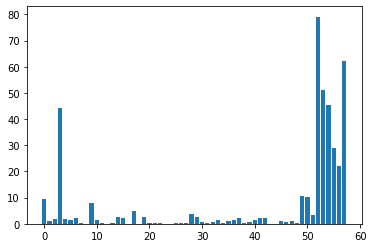

In [124]:
x = data.drop(columns=['loandecision'])
x_int = x[x.columns[0:2]] 
x_noint = x.drop(columns=x.columns[0:2]) 
x = x_noint 

fs = SelectKBest(chi2, k=10)
x_new = fs.fit_transform(x, y)

for i in range(len(fs.scores_)):
 	print('%s: %f' % (x_noint.columns[i], fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

**Mutual Information measure**

btype_Manufacturing: 0.000000
btype_Services: 0.017380
btype_Trading: 0.000000
btype_Unknown: 0.007627
bactivity_Job Work: 0.000000
bactivity_Job Work & Sales: 0.022453
bactivity_Retail: 0.000000
bactivity_Retail (Business to Business): 0.000000
bactivity_Retail (Business to Customer): 0.000000
bactivity_Sales: 0.000000
bactivity_Whole Sale: 0.000000
bsector_Agriculture: 0.000000
bsector_Apparel: 0.000000
bsector_Auto Components: 0.008357
bsector_Automobiles: 0.000590
bsector_Bedding: 0.002243
bsector_Bedding Industry: 0.007374
bsector_Book Stores: 0.000000
bsector_Chemicals: 0.009007
bsector_Construction: 0.015438
bsector_Construction Material: 0.000000
bsector_Electrical: 0.000000
bsector_Electricals: 0.000000
bsector_Electronics: 0.012881
bsector_Fabrication: 0.002360
bsector_Fashion: 0.000000
bsector_Food & Beverage: 0.000000
bsector_Food Products: 0.000000
bsector_Furniture: 0.014508
bsector_General: 0.011156
bsector_Handicrafts: 0.000000
bsector_Health & Beauty: 0.002840
bsector_

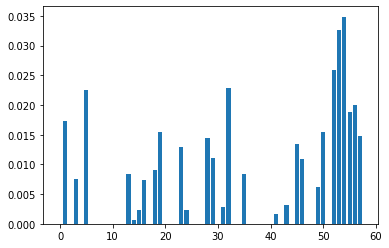

In [125]:
x = data.drop(columns=['loandecision'])
x_int = x[x.columns[0:2]] 
x_noint = x.drop(columns=x.columns[0:2]) 
x = x_noint 

fs = SelectKBest(mutual_info_classif, k=15)
x_new = fs.fit_transform(x, y)

for i in range(len(fs.scores_)):
 	print('%s: %f' % (x_noint.columns[i], fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

**It shows that both numerical features are good to keep.
Top 10 categorical features(from Chi-square) and Top 15 categorical features(from mutual information) are also good to keep.
I will use three dataset to conduct following modeling part.**
1. two numerical features with all categorical features
2. two numerical features with 10 categorical features chosen from Chi-square test.
3. two numerical features with 15 categorical features chosen from mutual information measures.

**The following modeling is conducted only by the second dataset. Two numerical features with 10 categorical features chosen from Chi-square test.**

In [127]:
x = data.drop(columns=['loandecision'])
x_int = x[x.columns[0:2]] 
x_noint = x.drop(columns=x.columns[0:2]) 
x = x_noint 

fs = SelectKBest(chi2, k=10)
x_new = fs.fit_transform(x, y)

x = pd.DataFrame(x_new) 
x = pd.concat([x, x_int], axis=1) 
x = x.rename(str, axis='columns')
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0) 
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   0                          2348 non-null   uint8  
 1   1                          2348 non-null   uint8  
 2   2                          2348 non-null   uint8  
 3   3                          2348 non-null   uint8  
 4   4                          2348 non-null   uint8  
 5   5                          2348 non-null   uint8  
 6   6                          2348 non-null   uint8  
 7   7                          2348 non-null   uint8  
 8   8                          2348 non-null   uint8  
 9   9                          2348 non-null   uint8  
 10  ManagAgeui_APP             2348 non-null   float64
 11  total_disbursement_amount  2348 non-null   float64
dtypes: float64(2), uint8(10)
memory usage: 59.7 KB


**1. Random Forest with cross validation**

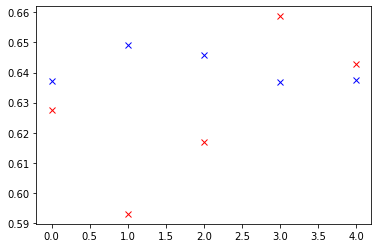

In [134]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4)  ## max_depth=3
scores = cross_validate(clf, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True, return_estimator=True)

T = scores['train_score']
F = scores['test_score']
plt.plot(T,'bx')
plt.plot(F,'rx')
plt.show()
#blue point is training accuracy, red point is validation accuracy.

In [135]:
model = scores['estimator'][4]
yp = model.predict(x_test)
accuracy_score(y_test, yp)
##Best test accuracy

0.6425531914893617

**2. Neural Network**

In [139]:
length = len(x.columns)
def NN_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=length, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = NN_model()
model.summary()

#model.fit(x_train, y_train, batch_size=50, validation_data=(x_test, y_test), epochs=100, verbose=1) 
#scores = model.evaluate(x_test, y_test)
#print("Accuracy: %.2f%%" % (scores[1]*100))  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                260       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 40)                840       
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
____________________________________________________

Neural Network models have some issue running on notebook, but it perform good on Spyder. The validation accuracy is 0.6.

**3. Kernel SVM**

[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [186   2]]
[[274   8]
 [174  14]]
[[264  18]
 [163  25]]
[[267  15]


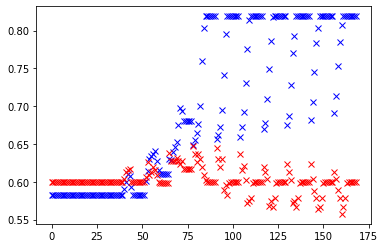

In [147]:
######################### kernel SVM
b = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
F = []
T = []

for i in range(13):
    for j in range(13):
        classifier = SVC(kernel = 'rbf', C = b[i], gamma = b[j])
        classifier.fit(x_train, y_train)
        yp = classifier.predict(x_test)
        tp = classifier.predict(x_train)
        F.append(accuracy_score(y_test, yp))
        T.append(accuracy_score(y_train, tp))
        print(confusion_matrix(y_test, yp))
        
plt.plot(T,'bx')
plt.plot(F,'rx')
plt.show()
#blue point is training accuracy, red point is validation accuracy.

In [148]:
print(np.max(F))
##Best test accuracy

0.6468085106382979


**4. Logistic Regression**

0.6
[[ 12 270]
 [  5 183]]
[[ 13 269]
 [  6 182]]
[[ 16 266]
 [  6 182]]
[[ 16 266]
 [  7 181]]
[[ 44 238]
 [ 18 170]]
[[ 44 238]
 [ 20 168]]
[[ 60 222]
 [ 29 159]]
[[ 72 210]
 [ 31 157]]
[[207  75]
 [149  39]]
[[207  75]
 [149  39]]
[[210  72]
 [151  37]]
[[261  21]
 [173  15]]
[[274   8]
 [182   6]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]
[[282   0]
 [188   0]]


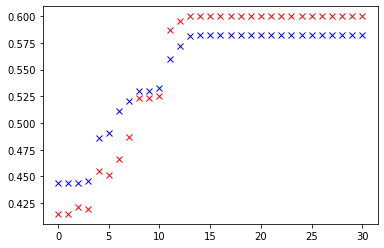

In [149]:
#################################### LOGISTIC
b = np.arange(0.35, 0.65, 0.01).tolist()
F = []
T = []

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(accuracy_score(y_test, y_pred))

for i in range(len(b)):
    yp = (logreg.predict_proba(x_test)[:,1] > b[i]).astype(int)
    tp = (logreg.predict_proba(x_train)[:,1] > b[i]).astype(int)
    F.append(accuracy_score(y_test, yp))
    T.append(accuracy_score(y_train, tp))
    print(confusion_matrix(y_test, yp))
    
plt.plot(T,'bx')
plt.plot(F,'rx')
plt.show()
#blue point is training accuracy, red point is validation accuracy.

In [150]:
print(np.max(F))
##Best test accuracy

0.6


**5. LASSO Classification**

[[147 135]
 [ 57 131]]
[[170 112]
 [ 66 122]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 77 111]]
[[178 104]
 [ 78 110]]
[[185  97]
 [ 81 107]]
[[193  89]
 [ 88 100]]
[[207  75]
 [ 99  89]]
[[216  66]
 [100  88]]
[[219  63]
 [105  83]]
[[219  63]
 [105  83]]
[[219  63]
 [105  83]]
[[219  63]
 [105  83]]
[[222  60]
 [106  82]]
[[225  57]
 [109  79]]
[[234  48]
 [111  77]]
[[243  39]
 [118  70]]
[[247  35]
 [122  66]]
[[253  29]
 [133  55]]
[[263  19]
 [150  38]]
[[266  16]
 [158  30]]
[[267  15]
 [158  30]]
[[267  15]
 [158  30]]
[[267  15]
 [158  30]]
[[269  13]
 [159  29]]
[[272  10]
 [164  24]]
[[274   8]
 [170  18]]
[[147 135]
 [ 57 131]]
[[170 112]
 [ 66 122]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 76 112]]
[[176 106]
 [ 77 111]]
[[178 104]
 [ 78 110]]
[[185  97]
 [ 81 107]]
[[193  89]
 [ 88 100]]
[[207  75]
 [ 99  89]]
[[216  66]


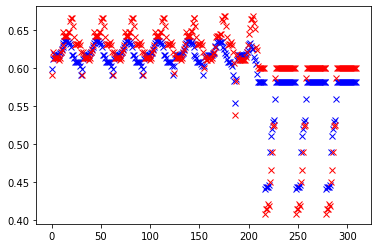

In [153]:
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3, 1e-2, 1, 5, 10]
b = np.arange(0.35, 0.65, 0.01).tolist()
F = []
T = []

for j in range(10):
    lasso = Lasso(alpha=alpha_lasso[j])
    lasso.fit(x_train,y_train)
    y_pred = lasso.predict(x_test)
    y_trainpred = lasso.predict(x_train)
    
    for i in range(len(b)):
        yp = (y_pred > b[i]).astype(int)
        tp = (y_trainpred > b[i]).astype(int)
        F.append(accuracy_score(y_test, yp))
        T.append(accuracy_score(y_train, tp))
        print(confusion_matrix(y_test, yp))
        
plt.plot(T,'bx')
plt.plot(F,'rx')
plt.show()
#blue point is training accuracy, red point is validation accuracy.

In [154]:
print(np.max(F))
##Best test accuracy

0.6680851063829787


**It shows LASSO Classification achieved the best test accuracy of 0.668 when alpha = 1e-2 and threshold is around 0.5 for the second set of data**

**Similar results are shown on the first and third sets of data, but LASSO Classification model trained by the second dataset still got the highest test accuracy of 66.8%, which is my current final model.**

**In the future, this model could be boosted by applying better dimension reduction methods, and better transforming the data, or incorporating more features to the dataset.**